In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.optimize import minimize_scalar
from scipy import signal
import statsmodels.api as sm
from scipy.stats import norm

### Replication of single-run plots

In [2]:
df = pd.read_csv('validation_samples/valoutput_1.csv')
df.head()

,GDP,C,I,prices,TotDebt,EnDem,U,Em,EmIndex
0,535595.571583,544792.075012,13516.286829,1.437814,1558.364915,335582.317344,0.0004,308882.652279,100.000000
1,535725.110607,544661.908459,14765.678713,1.438796,102.854609,335220.885627,0.0012,308498.060395,99.875489
2,538142.010827,543343.457296,15967.378438,1.443603,703.869075,334987.508537,0.0012,308211.286634,99.782647
3,544555.953680,543827.315417,18025.439488,1.451370,2680.897754,335976.224173,0.0008,309070.254059,100.060736
4,547614.113442,543557.752051,18677.099926,1.455879,3485.410578,336710.899117,0.0004,309690.695840,100.261602


In [3]:
T = range(len(df.GDP))

In [4]:
x = np.arange(0, 361, 60)
years = np.arange(2020, 2051, 5)

In [5]:
def indexnumber(ts):
    return 100 * ts / ts[0]

In [6]:
real_GDP = df.GDP / df.prices

(Partial) replication of Lamperti et al (2018) fig 2

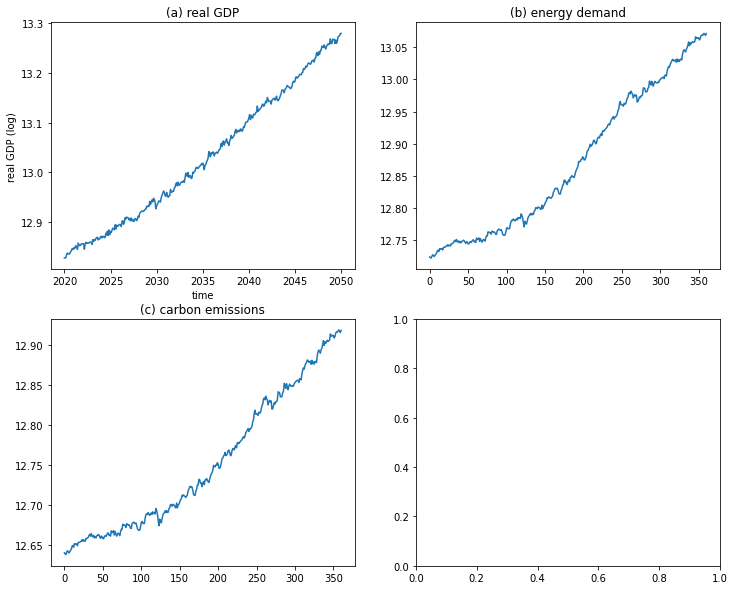

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

ax[0,0].plot(T, np.log(real_GDP))
ax[0,0].set_xlabel('time')
ax[0,0].set_ylabel('real GDP (log)')
ax[0,0].set_title('(a) real GDP')
ax[0,0].set_xticks(x, years)

ax[0,1].plot(T, np.log(df.EnDem))
ax[0,1].set_title('(b) energy demand')

ax[1,0].plot(T, np.log(df.Em))
ax[1,0].set_title('(c) carbon emissions')


plt.show()

(Partial) replication of Lamperti et al (2018) fig 7

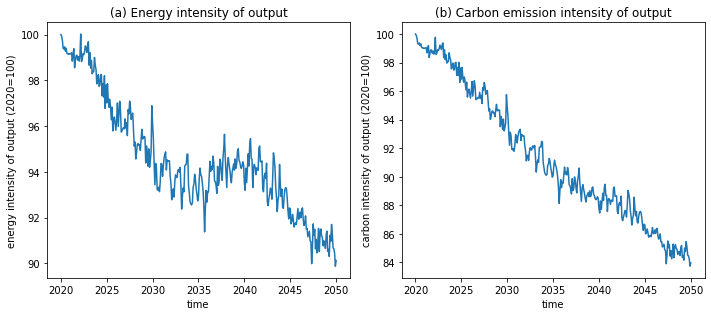

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4.5))

ax[0].plot(T, indexnumber(df.EnDem / real_GDP))
ax[0].set_xlabel('time')
ax[0].set_ylabel('energy intensity of output (2020=100)')
ax[0].set_title('(a) Energy intensity of output')
ax[0].set_xticks(x, years)

ax[1].plot(T, indexnumber(df.Em / real_GDP))
ax[1].set_xlabel('time')
ax[1].set_ylabel('carbon intensity of output (2020=100)')
ax[1].set_title('(b) Carbon emission intensity of output')
ax[1].set_xticks(x, years)

plt.tight_layout()
plt.show()

(Partial) replication of Lamperti et al (2018) fig 8

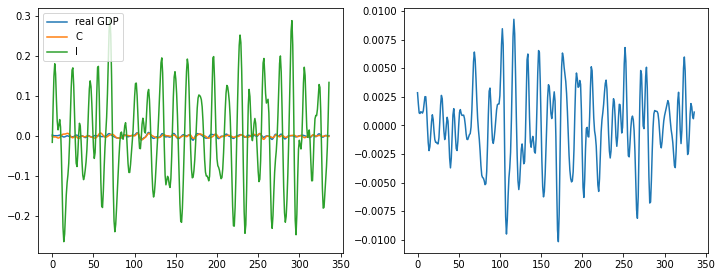

In [9]:
bk_low = 6
bk_high = 32
bk_K = 12

gdp_filtered = sm.tsa.filters.bkfilter(np.log(real_GDP), bk_low, bk_high, bk_K)
C_filtered = sm.tsa.filters.bkfilter(np.log(df.C), bk_low, bk_high, bk_K)
I_filtered = sm.tsa.filters.bkfilter(np.log(df.I), bk_low, bk_high, bk_K)

T_filter = range(len(gdp_filtered))

fig, ax = plt.subplots(1, 2, figsize=(12, 4.5))

ax[0].plot(T_filter, gdp_filtered, label='real GDP')
ax[0].plot(T_filter, C_filtered, label='C')
ax[0].plot(T_filter, I_filtered, label='I')
ax[0].legend()

ax[1].plot(T_filter, gdp_filtered)

plt.show()

Dosi et al (2017) fig 2

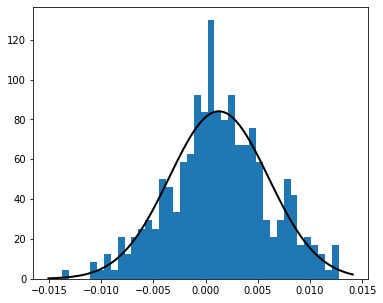

## Aggregate results

In [26]:
def filepath(i):
    return f'validation_samples/valoutput_{i}.csv'

In [27]:
n_MC = 10

df_list = []
for MC_i in range(1, n_MC + 2):
    df_list.append(pd.read_csv(filepath(MC_i)))
df = pd.concat(df_list)

In [33]:
real_GDP = df.GDP / df.prices
# print(100 * (df.GDP / df.prices).pct_change().mean())

In [34]:
gdp_growth = real_GDP.pct_change()[1:]
print(gdp_growth.shape)


(3970,)


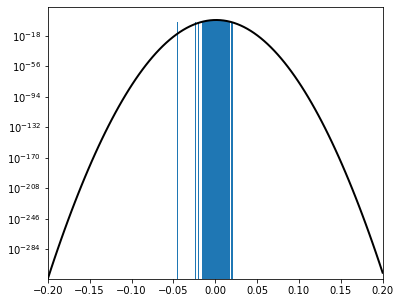

In [46]:
g = gdp_growth[np.abs(gdp_growth) <= 0.05]
mu, std = norm.fit(g)

plt.figure(figsize=(6,5))
plt.hist(g, density=True, bins=100)
plt.xlim(-0.2, 0.2)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

plt.yscale('log')

plt.show()

In [24]:
U_filtered = sm.tsa.filters.bkfilter(df.U, bk_low, bk_high, bk_K)
Em_filtered = sm.tsa.filters.bkfilter(np.log(df.Em), bk_low, bk_high, bk_K)
EnDem_filtered = sm.tsa.filters.bkfilter(np.log(df.EnDem), bk_low, bk_high, bk_K)
prices_filtered = sm.tsa.filters.bkfilter(np.log(df.prices), bk_low, bk_high, bk_K)


In [25]:
print(stats.pearsonr(gdp_filtered, C_filtered))
print(stats.pearsonr(gdp_filtered, I_filtered))
print(stats.pearsonr(gdp_filtered, U_filtered))
print(stats.pearsonr(gdp_filtered, Em_filtered))
print(stats.pearsonr(gdp_filtered, EnDem_filtered))
print(stats.pearsonr(gdp_filtered, prices_filtered))
print(np.var(C_filtered))
print(np.var(I_filtered))

(0.5635475705339623, 1.2259670306635808e-29)
(0.5206017901901835, 8.383627700520925e-25)
(-0.03514412395713385, 0.5202488321004013)
(-0.0037182915831590847, 0.9457813544538413)
(-0.02226662662019672, 0.6837930514442188)
(0.14309019860193853, 0.00852401241898116)
9.58914984495709e-06
0.013684015710670497


(Partial) replication of figure 4 in Lamperti et al (2018)

In [139]:
def compute_correlations(indicator):

    for lag in range(-2, 3):

        all_x = np.array([])
        all_y = np.array([])

        for df_part in df_list:

            # Apply filter
            real_GDP = (df_part['GDP']/df_part['prices']).to_numpy()
            gdp_filtered = sm.tsa.filters.bkfilter(real_GDP, bk_low, bk_high, bk_K)

            x = (df_part[indicator]/df_part['prices']).to_numpy()[-lag:]
            y = gdp_filtered[:lag]

            all_x = np.concatenate((all_x, x))
            all_y = np.concatenate((all_y, y))

        r, p = stats.pearsonr(all_x, all_y)
        print(lag, r, p)

compute_correlations('GDP')

-3 0.9986848075387481 0.0
-2 0.998939329924944 0.0
-1 0.9991009302230573 0.0


ValueError: x and y must have the same length.

In [ ]:
def compute_correlations(indicator):

    all_x = np.array([])
    all_y = np.array([])

    for df_part in df_list:

        # Apply filter
        real_GDP = (df_part['GDP']/df_part['prices']).to_numpy()
        gdp_filtered = sm.tsa.filters.bkfilter(real_GDP, bk_low, bk_high, bk_K)

    r, p = stats.pearsonr(all_x, all_y)

compute_correlations('GDP')

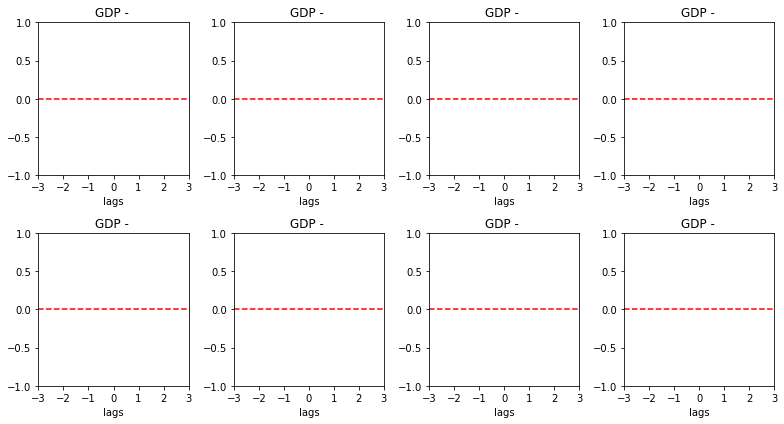

In [43]:
indicators = ['GDP']

fig, axes = plt.subplots(2,4, figsize=(11, 6))

# ax[0,0].plot()

for ax in axes.flatten():



    ax.hlines(0, -3., 3., linestyle='dashed', color='red')
    ax.set_ylim(-1., 1.)
    ax.set_xlim(-3., 3.)
    ax.set_xticks(np.linspace(-3, 3, 7))
    ax.set_yticks(np.linspace(-1, 1, 5))
    ax.set_title(f'GDP - ')
    ax.set_xlabel('lags')

plt.tight_layout()
plt.show()